C:\Anaconda\envs\yolov7_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Anaconda\envs\yolov7_env\lib\site-packages\torch\cuda\memory.py:278: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


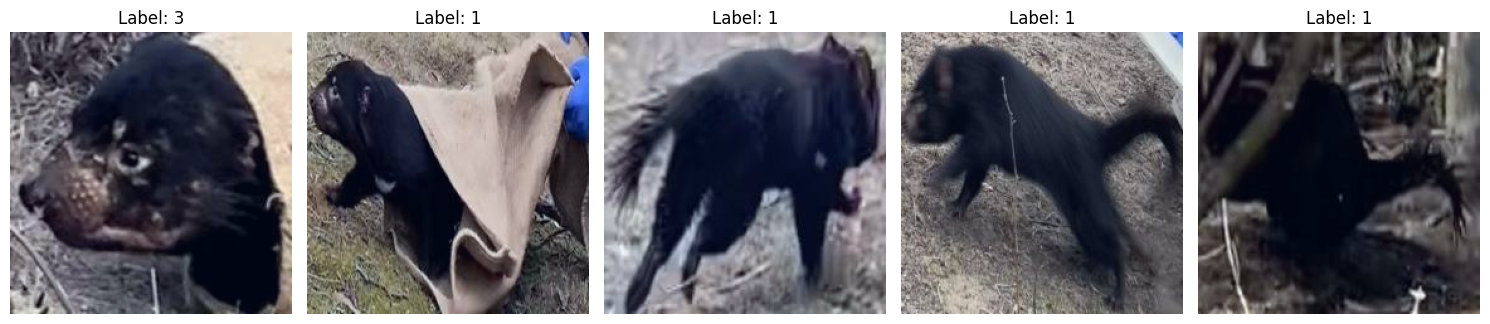

In [1]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import gc

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# === Paths ===
DATASET_PATH = r"D:\Master's Research\unified_dataset\split_age"

# === GPU memory cleanup ===
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_peak_memory_stats()
gc.collect()
torch.cuda.empty_cache()

# === Dataset Class (Age Only) ===
class WildlifeDataset(Dataset):
    def __init__(self, root_dir, class_names=None):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.image_paths = []
        self.labels = []

        self.classes = class_names if class_names else sorted(os.listdir(root_dir))

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            for dirpath, _, filenames in os.walk(class_dir):
                for img_name in filenames:
                    full_path = os.path.join(dirpath, img_name)
                    if not full_path.lower().endswith((".jpg", ".jpeg", ".png")):
                        continue  # Skip non-image files
                    self.image_paths.append(full_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        img_tensor = self.transform(image)
        label = self.labels[idx]
        return img_tensor, label, self.image_paths[idx]

    
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load metadata for label encoding
def load_metadata_dicts(excel_path):
    xls = pd.ExcelFile(excel_path)
    df1 = xls.parse('Fentonbury Apr_May 2024')
    df2 = xls.parse('Bronte')

    df1 = df1[['Individual_name', 'Sex', 'Age_years']]
    df2 = df2[['Individual_name', 'Sex', 'Age_years']]
    df = pd.concat([df1, df2], ignore_index=True)

    df['Individual_name'] = df['Individual_name'].astype(str).str.strip().str.lower()
    df['Sex'] = df['Sex'].astype(str).str.strip().str.lower()

    def map_age(age):
        if pd.isna(age):
            return None
        elif age >= 4:
            return 'more_than_4'
        else:
            return str(int(age))

    df['Age_Group'] = df['Age_years'].apply(map_age)
    df = df.dropna(subset=['Age_Group'])

    age_map = dict(zip(df['Individual_name'], df['Age_Group']))
    return age_map

# Load and fit encoder
metadata_excel_path = r"C:\Users\Jaylen LI\Downloads\1st_share\1st_share\All sites metadata for AI 2024_working copy.xlsx"
individual_to_age = load_metadata_dicts(metadata_excel_path)

age_label_encoder = LabelEncoder()
age_label_encoder.fit(list(set(individual_to_age.values())))

# === Shared Setup ===
shared_class_names = sorted([
    d.lower().strip() for d in os.listdir(os.path.join(DATASET_PATH, 'fold_1/train/images'))
    if os.path.isdir(os.path.join(DATASET_PATH, 'fold_1/train/images', d))
])
num_age_classes = len(shared_class_names)

# === Dataset Loaders ===
train_dataset = WildlifeDataset(
    os.path.join(DATASET_PATH, 'fold_1/train/images'),
    class_names=shared_class_names
)

val_dataset = WildlifeDataset(
    os.path.join(DATASET_PATH, 'fold_1/val/images'),
    class_names=shared_class_names
)

test_dataset = WildlifeDataset(
    os.path.join(DATASET_PATH, 'test/images'),
    class_names=shared_class_names
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# === Visual Debug: Show Sample Images ===
def show_example_images(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    random_indices = random.sample(range(len(dataset)), num_examples)

    for i, idx in enumerate(random_indices):
        image, label, img_path = dataset[idx]
        title = f"Label: {dataset.classes[label]}"
        image = image.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())

        axes[i].imshow(image)
        axes[i].set_title(title)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Run example visualization
show_example_images(train_dataset)


In [2]:
#Implement Cross-Attention Block (CAB)
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super().__init__()
        self.inner_patch_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.cross_patch_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x):
        # Inner-Patch Self-Attention (IPSA)
        x_residual = x
        x = self.ln1(x)
        x, _ = self.inner_patch_attention(x, x, x)
        x = x_residual + x  # Skip connection

        # Cross-Patch Self-Attention (CPSA)
        x_residual = x
        x = self.ln2(x)
        x, _ = self.cross_patch_attention(x, x, x)
        x = x_residual + x  # Skip connection
        
        # Feedforward MLP
        x = x + self.mlp(x)
        return x


In [3]:
#Implement ViT Backbone with Cross-Attention
class ViTBackbone(nn.Module):
    def __init__(self, depth=3):
        super().__init__()
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
        self.attentions = []

        # Register hook to capture attention maps
        def get_attention_hook(module, input, output):
            self.attentions.append(output)

        # Hook into all attention layers
        for blk in self.vit.blocks:
            blk.attn.register_forward_hook(get_attention_hook)

        self.cross_attention = nn.ModuleList([CrossAttentionBlock() for _ in range(depth)])

    def forward(self, x):
        self.attentions = []  # Reset attention storage
        x = self.vit.forward_features(x)
        for cab in self.cross_attention:
            x = cab(x)
        return x


In [4]:
# Locally Aware Network (LAN)
class LocallyAwareNetwork(nn.Module):
    def __init__(self, embed_dim=768, num_layers=7, lambda_weight=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.lambda_weight = lambda_weight
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        global_token = x[:, 0]               # CLS token
        local_tokens = x[:, 1:]              # Patch tokens
        fused = (local_tokens + self.lambda_weight * global_token.unsqueeze(1)) / (1 + self.lambda_weight)
        fused = fused.view(-1, self.num_layers, 28, 768)  # Reshape if needed
        fused = self.fc(fused)
        pooled = fused.mean(dim=2).mean(dim=1)
        return pooled


In [5]:
# Full CATLA Transformer with Multi-task Heads
class CATLATransformer(nn.Module):
    def __init__(self, num_individuals, num_sex_classes, num_age_classes):
        super().__init__()
        self.backbone = ViTBackbone(depth=3)  # From original CATLA paper
        self.lan = LocallyAwareNetwork()
        
        # Multi-task heads
        self.id_head = nn.Linear(768, num_individuals)
        self.sex_head = nn.Linear(768, num_sex_classes)
        self.age_head = nn.Linear(768, num_age_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.lan(x)
        age_logits = self.age_head(x)
        return age_logits



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CATLATransformer(
    num_individuals=0,  # Not used
    num_sex_classes=0,  # Not used
    num_age_classes=len(shared_class_names)
).to(device)

# Use separate losses for each task
loss_fn_id = nn.CrossEntropyLoss()
loss_fn_sex = nn.CrossEntropyLoss()
loss_fn_age = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)


C:\Anaconda\envs\yolov7_env\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [7]:
# Load partial checkpoint (ignore classifier mismatch)
checkpoint = torch.load("best_CATLA_Transformer.pth", map_location=device)

# Get current model parameters
model_dict = model.state_dict()

# Filter out mismatched keys (like classifier weights/bias)
filtered_dict = {k: v for k, v in checkpoint.items()
                 if k in model_dict and model_dict[k].shape == v.shape}

# Update model with compatible weights only
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)

print(f" Loaded {len(filtered_dict)} compatible parameters from checkpoint.")


 Loaded 198 compatible parameters from checkpoint.


In [8]:
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 30
patience = 5
best_val_acc = 0
counter = 0
early_stop = False
best_model_path = "earlystop_CATLA_age.pth"

train_losses, val_losses = [], []
train_accs_age, val_accs_age = [], []

true_train_age, pred_train_age = [], []
true_val_age, pred_val_age = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_age = 0
    total = 0

    for images, age_labels, paths in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
        images = images.to(device)
        age_labels = age_labels.to(device).long()

        optimizer.zero_grad()
        age_logits = model(images)

        true_train_age.extend(age_labels.cpu().numpy())
        pred_train_age.extend(age_logits.argmax(1).cpu().numpy())

        loss = ce_loss_fn(age_logits, age_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += images.size(0)
        correct_age += (age_logits.argmax(1) == age_labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accs_age.append(correct_age / total)

    # === Validation ===
    model.eval()
    val_loss = 0
    correct_age = 0
    total = 0

    with torch.no_grad():
        for images, age_labels, paths in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val"):
            images = images.to(device)
            age_labels = age_labels.to(device).long()

            age_logits = model(images)
            loss = ce_loss_fn(age_logits, age_labels)
            val_loss += loss.item()

            total += images.size(0)
            correct_age += (age_logits.argmax(1) == age_labels).sum().item()

            true_val_age.extend(age_labels.cpu().numpy())
            pred_val_age.extend(age_logits.argmax(1).cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accs_age.append(correct_age / total)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Age Acc: {train_accs_age[-1]:.4f} | Val Age Acc: {val_accs_age[-1]:.4f}")

    # Early stopping
    if val_accs_age[-1] > best_val_acc:
        best_val_acc = val_accs_age[-1]
        counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            early_stop = True
            break

if early_stop:
    model.load_state_dict(torch.load(best_model_path))
else:
    torch.save(model.state_dict(), "final_CATLA_age.pth")


Epoch 1 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.92it/s]


Epoch 1: Train Age Acc: 0.4256 | Val Age Acc: 0.4271


Epoch 2 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.59it/s]


Epoch 2: Train Age Acc: 0.5060 | Val Age Acc: 0.5000


Epoch 3 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.42it/s]


Epoch 3: Train Age Acc: 0.6429 | Val Age Acc: 0.5677


Epoch 4 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.53it/s]


Epoch 4: Train Age Acc: 0.7173 | Val Age Acc: 0.4635


Epoch 5 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.74it/s]


Epoch 5: Train Age Acc: 0.7560 | Val Age Acc: 0.5312


Epoch 6 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.40it/s]


Epoch 6: Train Age Acc: 0.8467 | Val Age Acc: 0.6510


Epoch 7 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.01it/s]


Epoch 7: Train Age Acc: 0.8616 | Val Age Acc: 0.6094


Epoch 8 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.40it/s]


Epoch 8: Train Age Acc: 0.8661 | Val Age Acc: 0.5990


Epoch 9 - Val: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.63it/s]


Epoch 9: Train Age Acc: 0.9375 | Val Age Acc: 0.6354


Epoch 10 - Val: 100%|██████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.58it/s]


Epoch 10: Train Age Acc: 0.9628 | Val Age Acc: 0.6406


Epoch 11 - Val: 100%|██████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.11it/s]


Epoch 11: Train Age Acc: 0.9926 | Val Age Acc: 0.6510
Early stopping triggered.


In [9]:
from sklearn.metrics import classification_report
import numpy as np

# Identify present labels for the current fold
train_labels_present = np.unique(true_train_age)
val_labels_present = np.unique(true_val_age)

# === AGE REPORTS ===
print("\n Final AGE Classification Report (Train):")
print(classification_report(
    true_train_age,
    pred_train_age,
    labels=train_labels_present,
    target_names=age_label_encoder.inverse_transform(train_labels_present)
))

print("\n Final AGE Classification Report (Validation):")
print(classification_report(
    true_val_age,
    pred_val_age,
    labels=val_labels_present,
    target_names=age_label_encoder.inverse_transform(val_labels_present)
))



 Final AGE Classification Report (Train):
              precision    recall  f1-score   support

           1       0.78      0.82      0.80      3696
           2       0.77      0.78      0.78      3080
           3       0.72      0.43      0.54       616

    accuracy                           0.77      7392
   macro avg       0.76      0.68      0.71      7392
weighted avg       0.77      0.77      0.77      7392


 Final AGE Classification Report (Validation):
              precision    recall  f1-score   support

           1       0.61      0.61      0.61      1056
           2       0.54      0.58      0.56       880
           3       0.52      0.26      0.35       176

    accuracy                           0.57      2112
   macro avg       0.55      0.49      0.51      2112
weighted avg       0.57      0.57      0.57      2112



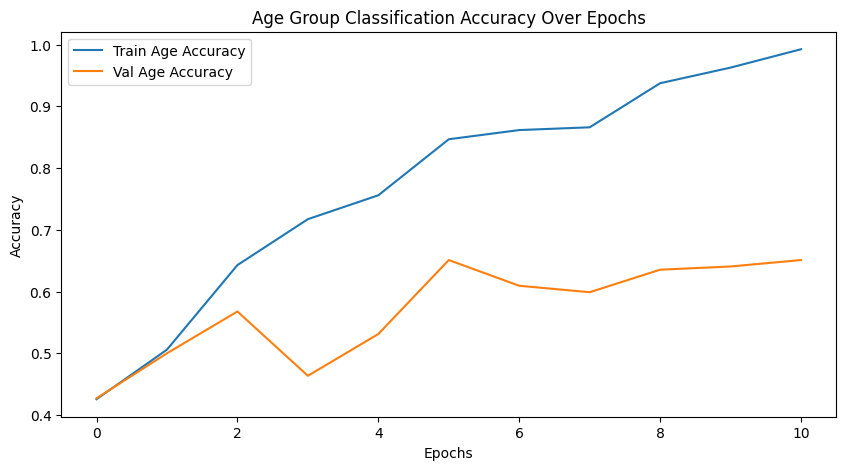

In [10]:
#Step 6.3: Plot Training & Validation Curves

plt.figure(figsize=(10, 5))
plt.plot(train_accs_age, label="Train Age Accuracy")
plt.plot(val_accs_age, label="Val Age Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Age Group Classification Accuracy Over Epochs")
plt.show()


In [11]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

# === Ensure model is on correct device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# === Initialize Storage ===
true_test_age, pred_test_age = [], []

# === Run Inference on Test Set (Age Only) ===
with torch.no_grad():
    for images, age_labels, paths in test_loader:
        images = images.to(device)
        age_labels = age_labels.to(device)

        logits = model(images)

        true_test_age.extend(age_labels.cpu().numpy())
        pred_test_age.extend(logits.argmax(dim=1).cpu().numpy())

# === Accuracy and F1 Score ===
acc_age = accuracy_score(true_test_age, pred_test_age)
f1_age = f1_score(true_test_age, pred_test_age, average="weighted")

print("\n Age Classification Metrics (Test):")
print(f"Accuracy: {acc_age:.4f} | F1 Score: {f1_age:.4f}")

# === Handle Label Mismatch Safely ===
unique_labels = np.unique(true_test_age)
target_names = age_label_encoder.inverse_transform(unique_labels)

print("\n Classification Report (Age):")
print(classification_report(true_test_age, pred_test_age, labels=unique_labels, target_names=target_names))



 Age Classification Metrics (Test):
Accuracy: 0.6940 | F1 Score: 0.6549

 Classification Report (Age):
              precision    recall  f1-score   support

           1       0.70      0.91      0.79       171
           2       0.68      0.42      0.52        91
           3       1.00      0.05      0.10        19

    accuracy                           0.69       281
   macro avg       0.79      0.46      0.47       281
weighted avg       0.71      0.69      0.65       281



In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

def save_classification_report(true_labels, pred_labels, label_encoder, file_path):
    """
    Save classification report to CSV with only valid target_names (present in labels).
    """
    labels_present = np.unique(true_labels)
    target_names_present = label_encoder.inverse_transform(labels_present)
    
    report_dict = classification_report(
        true_labels,
        pred_labels,
        labels=labels_present,
        target_names=target_names_present,
        output_dict=True
    )
    df = pd.DataFrame(report_dict).transpose()
    df.to_csv(file_path)
    print(f" Classification report saved to: {file_path}")

output_dir = r"D:\Master's Research\ViT+CATLA Transformer\results_age"

save_classification_report(true_train_age, pred_train_age, age_label_encoder,
    os.path.join(output_dir, "fold_report_train_age.csv"))

save_classification_report(true_val_age, pred_val_age, age_label_encoder,
    os.path.join(output_dir, "fold_report_val_age.csv"))

save_classification_report(true_test_age, pred_test_age, age_label_encoder,
    os.path.join(output_dir, "fold_report_test_age.csv"))


 Classification report saved to: D:\Master's Research\ViT+CATLA Transformer\results_age\fold_report_train_age.csv
 Classification report saved to: D:\Master's Research\ViT+CATLA Transformer\results_age\fold_report_val_age.csv
 Classification report saved to: D:\Master's Research\ViT+CATLA Transformer\results_age\fold_report_test_age.csv


✅ Saved: D:\Master's Research\ViT+CATLA Transformer\results_age\fold5_cm_test_age.csv


C:\Users\Jaylen LI\AppData\Local\Temp\ipykernel_4904\3756410841.py:12: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


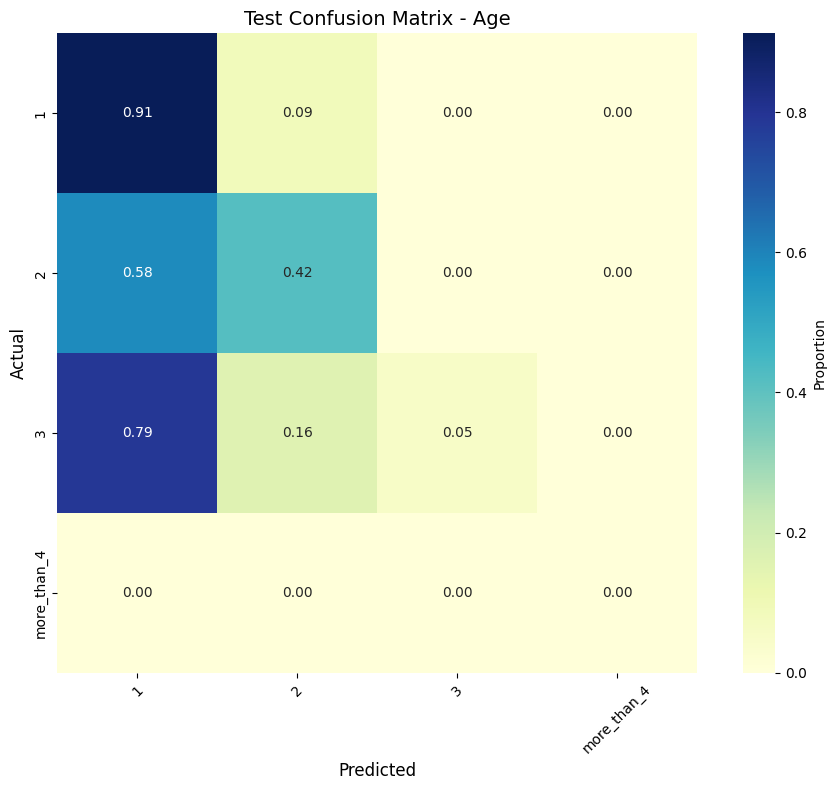

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, pred_labels, class_names,
                          dataset_name="Confusion Matrix", file_path=None):
    labels = list(range(len(class_names)))
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)

    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    if file_path:
        df_cm = pd.DataFrame(cm_norm, index=class_names, columns=class_names)
        df_cm.to_csv(file_path)
        print(f"✅ Saved: {file_path}")

    plt.figure(figsize=(10, 8))  # slightly smaller
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=class_names,
        yticklabels=class_names,
        square=True,
        cbar_kws={"label": "Proportion"}
    )
    plt.title(dataset_name, fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

output_dir = r"D:\Master's Research\ViT+CATLA Transformer\results_age"


# === Age Classification ===
plot_confusion_matrix(
    true_test_age,
    pred_test_age,
    age_label_encoder.classes_,
    dataset_name="Test Confusion Matrix - Age",
    file_path=os.path.join(output_dir, "fold5_cm_test_age.csv")
)


In [14]:
import torch
from torch.nn.functional import softmax, sigmoid
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

def plot_multiclass_roc(true_labels, pred_probs, class_names, title="ROC Curve", save_path=None, auc_csv_path=None):
    """
    Plot ROC curves and export AUC scores to CSV.
    Handles both binary and multi-class settings.
    """
    num_classes = pred_probs.shape[1]
    
    # 🛠 Ensure label_binarize outputs shape (N, num_classes)
    unique_classes = sorted(np.unique(true_labels))
    true_bin = label_binarize(true_labels, classes=list(range(num_classes)))

    if true_bin.shape[1] == 1 and num_classes == 2:
        # Convert (502, 1) → (502, 2) for binary classification
        true_bin = np.hstack([1 - true_bin, true_bin])

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(12, 7))

    for i in range(num_classes):
        if i >= pred_probs.shape[1]:
            print(f" Skipping class {i} due to insufficient prediction dimensions.")
            continue

        if np.sum(true_bin[:, i]) == 0:
            print(f" Skipping class {i} due to no positive samples.")
            continue

        y_score = pred_probs[:, i]
        fpr[i], tpr[i], _ = roc_curve(true_bin[:, i], y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
        label = class_names[i] if i < len(class_names) else f"Class {i}"
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.,
        fontsize='small'
    )

    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f" ROC curve saved to: {save_path}")
    else:
        plt.show()

    if auc_csv_path:
        auc_data = {class_names[i]: [roc_auc[i]] for i in roc_auc}
        auc_df = pd.DataFrame(auc_data).T
        auc_df.columns = ["AUC"]
        os.makedirs(os.path.dirname(auc_csv_path), exist_ok=True)
        auc_df.to_csv(auc_csv_path)
        print(f" AUC scores saved to: {auc_csv_path}")


In [15]:
true_test_age, pred_test_age = [], []
age_logits_test = []

model.eval()
with torch.no_grad():
    for images, labels, paths in tqdm(test_loader, desc="Test Inference – Age"):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)

        # True + predicted labels
        true_test_age.extend(labels.cpu().numpy())
        pred_test_age.extend(logits.argmax(dim=1).cpu().numpy())

        # For ROC
        age_logits_test.append(logits.cpu())

# Stack logits for all batches
age_logits_test = torch.cat(age_logits_test, dim=0)


Test Inference – Age: 100%|████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 24.81it/s]


true_test_age: 281
age_logits_test: torch.Size([281, 3])
age_probs_test: (281, 3)
 ROC curve saved to: D:\Master's Research\ViT+CATLA Transformer\results_age\roc_test_age.png
 AUC scores saved to: D:\Master's Research\ViT+CATLA Transformer\results_age\roc_test_age_auc.csv


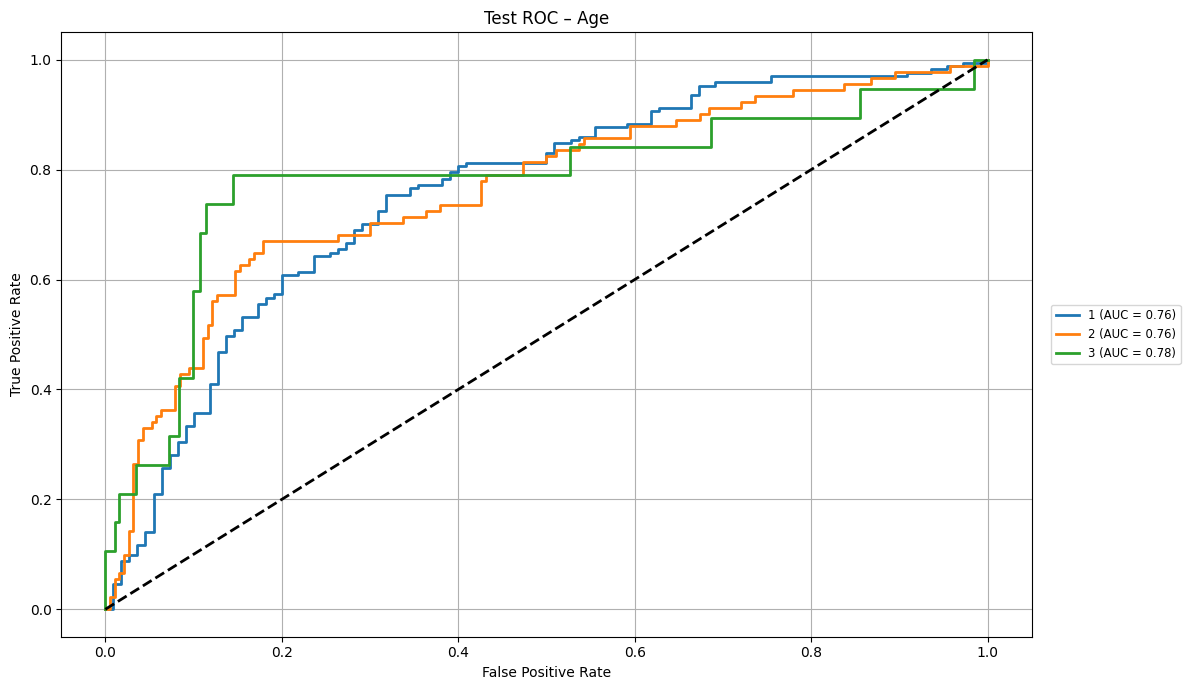

In [16]:
from torch.nn.functional import softmax

# Apply softmax to age logits
age_probs_test = softmax(age_logits_test, dim=1).cpu().numpy()

# Optional: print shapes
print("true_test_age:", len(true_test_age))
print("age_logits_test:", age_logits_test.shape)
print("age_probs_test:", age_probs_test.shape)

# Plot ROC Curve
plot_multiclass_roc(
    true_test_age,
    age_probs_test,
    age_label_encoder.classes_,
    title="Test ROC – Age",
    save_path=r"D:\Master's Research\ViT+CATLA Transformer\results_age\roc_test_age.png",
    auc_csv_path=r"D:\Master's Research\ViT+CATLA Transformer\results_age\roc_test_age_auc.csv"
)


In [17]:
'''
import os
from PIL import Image
import pandas as pd

# Root path to analyze
dataset_root = r"D:\Master's Research\unified_dataset\final_split_safe"

# Results
summary = []
resolution_data = []

# Walk through all fold_X/train|val/images and test/images
for root, dirs, files in os.walk(dataset_root):
    if "images" not in root:
        continue

    for class_dir in dirs:
        class_path = os.path.join(root, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Extract split and set
        path_parts = os.path.normpath(class_path).split(os.sep)
        if 'test' in path_parts:
            split = 'test'
            set_type = 'test'
        else:
            split = path_parts[-4]  # e.g., fold_1
            set_type = path_parts[-3]  # train or val

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    resolution_data.append({
                        "Split": split,
                        "Set": set_type,
                        "Class": class_dir,
                        "Image": img_file,
                        "Width": width,
                        "Height": height
                    })
            except Exception as e:
                print(f"❌ Error reading {img_path}: {e}")
                continue

        summary.append({
            "Split": split,
            "Set": set_type,
            "Class": class_dir,
            "Num_Images": len(image_files)
        })

# Convert to DataFrames
df_summary = pd.DataFrame(summary)
df_res = pd.DataFrame(resolution_data)

# Pivot for image count table
pivot_summary = df_summary.pivot_table(index=['Split', 'Set'], columns='Class', values='Num_Images', aggfunc='sum').fillna(0).astype(int)

# Resolution stats
res_stats = df_res.groupby(['Split', 'Set', 'Class'])[['Width', 'Height']].agg(['min', 'max', 'mean']).round(1)

# Save to Excel
output_file = os.path.join(dataset_root, "dataset_analysis.xlsx")
with pd.ExcelWriter(output_file) as writer:
    df_summary.to_excel(writer, sheet_name="Image_Counts", index=False)
    df_res.to_excel(writer, sheet_name="Resolutions", index=False)
    res_stats.to_excel(writer, sheet_name="Resolution_Stats")

print(f" Dataset analysis saved to: {output_file}")
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 114-115: truncated \uXXXX escape (3093794599.py, line 1)